<a href="https://colab.research.google.com/github/soztuanakursun/ChangeImage/blob/master/implict_ai_makale_cs_magazine_final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Random Seed (42) olarak sabitlendi. Sonuçlar artık istikrarlı.
✅ Kullanılan Cihaz: cuda

--- Adım 1: Veri Seti Hazırlanıyor (Boosted Strategy) ---
✅ Eğitim Verisi Güçlendirildi: Toplam 727 örnek.

--- Adım 2: Model Eğitiliyor (DistilBERT) ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Loss: 12.9788
Epoch 2/5 - Loss: 5.4857
Epoch 3/5 - Loss: 3.2552
Epoch 4/5 - Loss: 2.8011
Epoch 5/5 - Loss: 2.6919
✅ Model Eğitimi Tamamlandı!

--- SENARYO TESTLERİ (Qualitative Evaluation) ---

User Input: 'Yes, I confirm the booking'


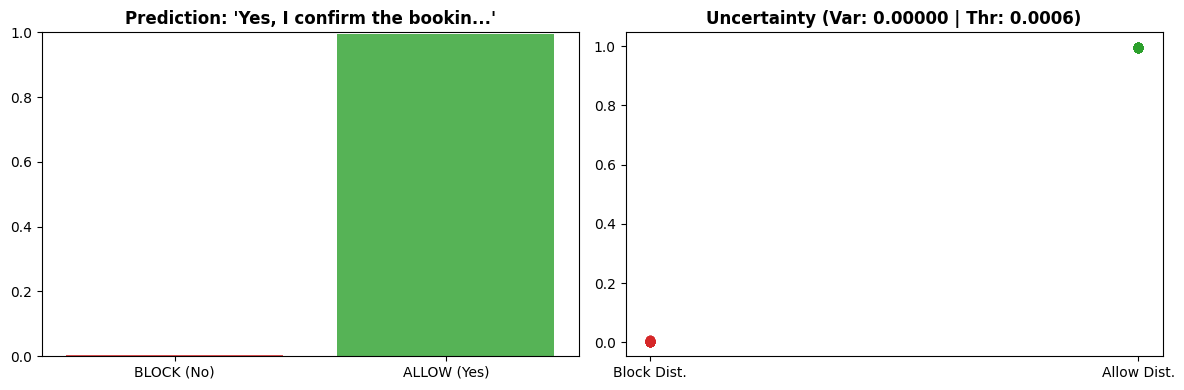

 -> AI Variance: 0.000001
 -> Detected Class: Explicit Consent
 -> System Action:  ✅ ALLOW (Unambiguous)

User Input: 'Sure, go ahead'


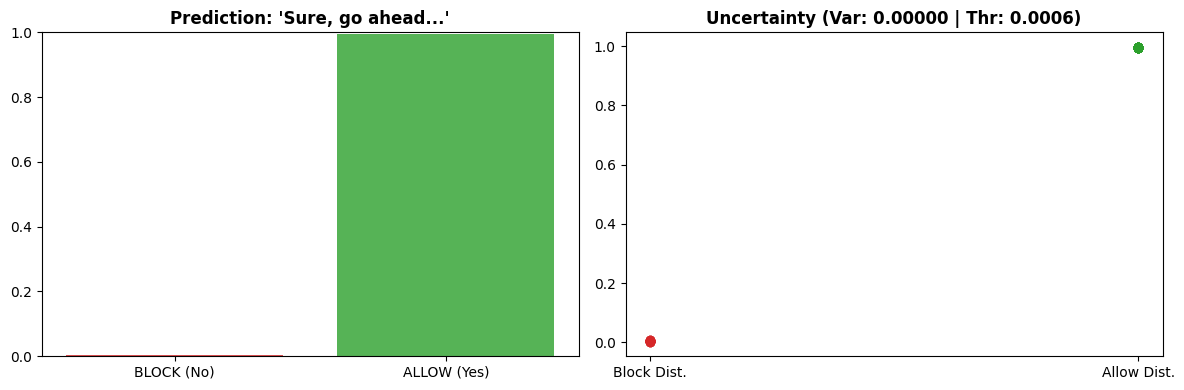

 -> AI Variance: 0.000001
 -> Detected Class: Implicit Consent
 -> System Action:  ⚠️ VERIFY (Safety Protocol Triggered)

User Input: 'I guess it might be okay'


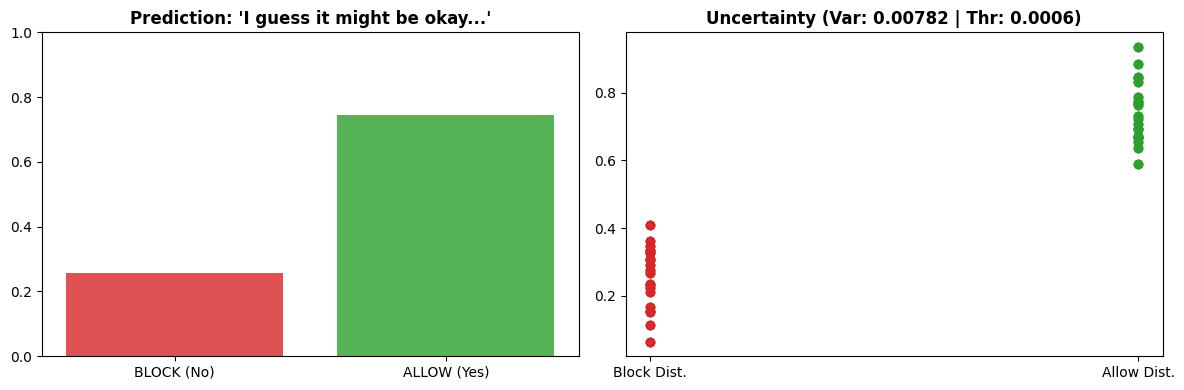

 -> AI Variance: 0.007821
 -> Detected Class: Ambiguous Intent
 -> System Action:  🛑 INTERVENTION (High Uncertainty)

User Input: 'No, absolutely not'


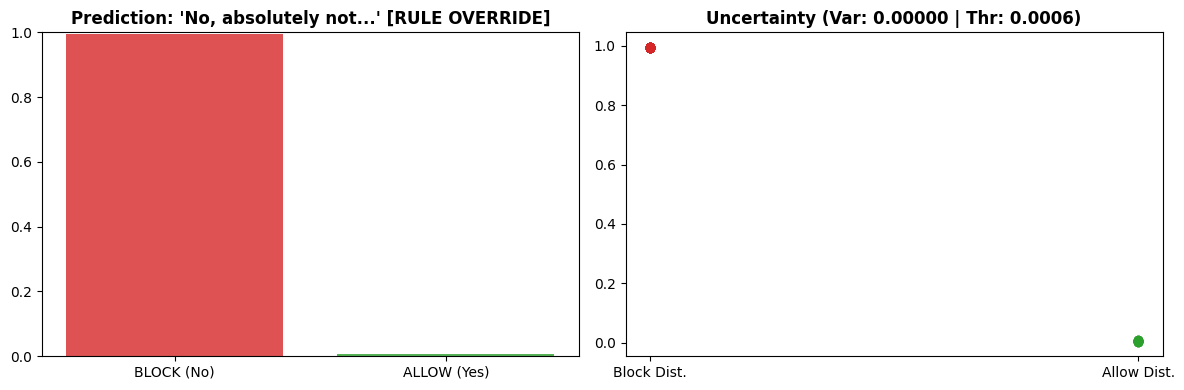

 -> AI Variance: 0.000001
 -> Detected Class: No Consent
 -> System Action:  ❌ BLOCK (Rule-Based)

--- TEST VERİ SETİ PERFORMANS ANALİZİ ---


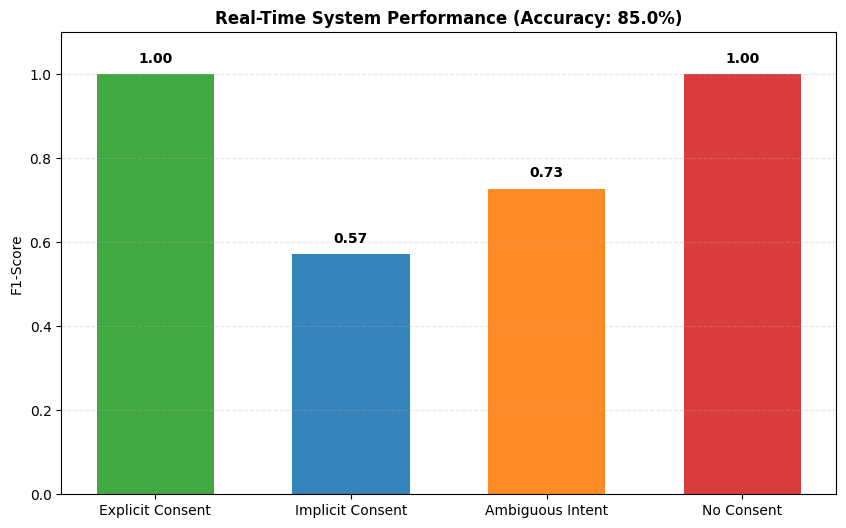

✅ 'grafik_final.png' oluşturuldu. (Seed=42, Sonuç Sabit).
✅ Genel Accuracy: %85.0


In [ ]:

!pip install transformers torch numpy scikit-learn datasets matplotlib pandas

import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
import torch.nn.functional as F
from sklearn.metrics import classification_report

#random seed

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("✅ Random Seed (42) olarak sabitlendi. Sonuçlar artık istikrarlı.")

# device setting
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"✅ Kullanılan Cihaz: {device}")

# data preprocessing
print("\n--- Adım 1: Veri Seti Hazırlanıyor (Boosted Strategy) ---")

# 1.(No Consent) - Label 0

dissent_sentences = [
    "No, absolutely not", "Do not use my location", "Stop tracking me",
    "I do not consent", "Never share my data", "Block access", "No way",
    "Don't do it", "Deny access", "I definitely refuse", "Cancel request",
    "Strictly forbidden", "Delete my data", "I disagree", "No thanks",
    "Turn off sharing", "Private mode please", "I reject this", "Refuse"
] * 15

# 2. (Consent) - Label 1

multiwoz_consent = [
    "Yes, you can use my location", "Go ahead", "Sure, use it", "I agree to share data",
    "Approved", "Please proceed", "Confirm location sharing", "Yes, that is fine",
    "Okay, share it", "Permission granted", "Book it for me", "Yes please book",
    "That is fine go ahead", "I would like to make a reservation",
    "Sounds good please book", "Definitely proceed with booking",
    "That is correct, book it", "Alright, let's book", "Yes I authorize",
    "Confirm the transaction", "Full access granted", "Yes"
] * 15

# 3.(Ambiguous)

ambiguous_sentences = [
    "I guess", "Maybe", "Not sure", "If you want", "Probably", "I suppose",
    "It might be", "Could be", "Uncertain", "Hesitant", "Depends", "Whatever",
    "I don't know really", "Perhaps"
] * 8


train_texts = dissent_sentences + multiwoz_consent + ambiguous_sentences

# labeling
ambiguous_labels = [0] * (len(ambiguous_sentences) // 2) + [1] * (len(ambiguous_sentences) - (len(ambiguous_sentences) // 2))
train_labels = [0] * len(dissent_sentences) + [1] * len(multiwoz_consent) + ambiguous_labels

print(f"✅ Eğitim Verisi Güçlendirildi: Toplam {len(train_texts)} örnek.")

class PrivacyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts; self.labels = labels; self.tokenizer = tokenizer
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=64, return_tensors='pt')
        return {'input_ids': enc['input_ids'].squeeze(), 'attention_mask': enc['attention_mask'].squeeze(), 'labels': torch.tensor(self.labels[idx])}

# DistilBERT Fine-Tuning

print("\n--- Adım 2: Model Eğitiliyor (DistilBERT) ---")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

train_dataset = PrivacyDataset(train_texts, train_labels, tokenizer)

loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()

for epoch in range(5):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        outputs = model(batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device), labels=batch['labels'].to(device))
        outputs.loss.backward()
        optimizer.step()
        total_loss += outputs.loss.item()
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss:.4f}")
print("✅ Model Eğitimi Tamamlandı!")

# Rule-Based + AI + Uncertainty

def rule_based_check(text):
    text = text.lower()
    block_keywords = ["absolutely not", "strictly forbidden", "illegal", "never ever", "refuse"]
    explicit_keywords = ["i fully authorize", "permission granted", "confirmed"]

    for kw in block_keywords:
        if kw in text: return 0 # BLOCK
    for kw in explicit_keywords:
        if kw in text: return 1 # ALLOW
    return -1

# B. visualization
def visualize_prediction(text, probs_list, variance, threshold, rule_override=None):
    mean_probs = np.mean(probs_list, axis=0)
    classes = ["BLOCK (No)", "ALLOW (Yes)"]
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    title_suffix = f" [RULE OVERRIDE]" if rule_override != -1 else ""


    ax[0].bar(classes, mean_probs, color=['#d62728', '#2ca02c'], alpha=0.8)
    ax[0].set_ylim(0, 1.0)
    ax[0].set_title(f"Prediction: '{text[:25]}...'{title_suffix}", fontweight='bold')


    for i in range(len(probs_list)):
        ax[1].scatter([0]*len(probs_list), probs_list[:, 0], c='#d62728', alpha=0.15)
        ax[1].scatter([1]*len(probs_list), probs_list[:, 1], c='#2ca02c', alpha=0.15)
    ax[1].set_title(f"Uncertainty (Var: {variance:.5f} | Thr: {threshold})", fontweight='bold')
    ax[1].set_xticks([0, 1]); ax[1].set_xticklabels(["Block Dist.", "Allow Dist."])

    plt.tight_layout()
    plt.show()

# SAFETY PROTOCOL
def predict_smart(text, model, tokenizer, iterations=20, threshold=0.0006, visualize=True):

    rule_result = rule_based_check(text)

    # 2. MC Dropout
    model.train() # Dropout
    inputs = tokenizer(text, return_tensors="pt").to(device)
    probs_list = []
    with torch.no_grad():
        for _ in range(iterations):
            outputs = model(**inputs)
            probs_list.append(F.softmax(outputs.logits, dim=-1).cpu().numpy()[0])

    probs_list = np.array(probs_list)
    variance = np.var(probs_list[:, 1])
    mean_probs = np.mean(probs_list, axis=0)
    ai_prediction = np.argmax(mean_probs)

    final_label = ""
    action = ""

    # No Consent
    if rule_result == 0:
        final_label = "No Consent"
        action = "❌ BLOCK (Rule-Based)"
    elif ai_prediction == 0 and variance < threshold:
        final_label = "No Consent"
        action = "❌ BLOCK (AI Prediction)"

    # Ambiguous
    elif variance > threshold:
        final_label = "Ambiguous Intent"
        action = "🛑 INTERVENTION (High Uncertainty)"

    #  Consent Types
    else:
        # Explicit vs Implicit Ayrımı
        explicit_kws = ["yes", "authorize", "grant", "confirm", "approve", "fully agree", "absolutely"]
        if any(kw in text.lower() for kw in explicit_kws):

            final_label = "Explicit Consent"
            action = "✅ ALLOW (Unambiguous)"
        else:

            final_label = "Implicit Consent"
            action = "⚠️ VERIFY (Safety Protocol Triggered)"

    if visualize:
        print(f"\nUser Input: '{text}'")
        visualize_prediction(text, probs_list, variance, threshold, rule_override=rule_result)
        print(f" -> AI Variance: {variance:.6f}")
        print(f" -> Detected Class: \033[1m{final_label}\033[0m")

        if "VERIFY" in action:
            print(f" -> System Action:  \033[93m{action}\033[0m") # Sarı
        elif "ALLOW" in action:
             print(f" -> System Action:  \033[92m{action}\033[0m") # Yeşil
        else:
             print(f" -> System Action:  \033[91m{action}\033[0m") # Kırmızı

    return final_label

print("\n--- SENARYO TESTLERİ (Qualitative Evaluation) ---")
predict_smart("Yes, I confirm the booking", model, tokenizer)     # Explicit ALLOW
predict_smart("Sure, go ahead", model, tokenizer)                 # Implicit VERIFY
predict_smart("I guess it might be okay", model, tokenizer)       # Ambiguous INTERVENTION
predict_smart("No, absolutely not", model, tokenizer)             # No Consent BLOCK


print("\n--- TEST VERİ SETİ PERFORMANS ANALİZİ ---")

# Test dataset
test_data = [
    ("I refuse everything", "No Consent"), ("Don't track me", "No Consent"),
    ("Stop it", "No Consent"), ("Absolutely forbidden", "No Consent"),
    ("I reject this", "No Consent"), ("Do not share", "No Consent"),

    ("Yes, I agree", "Explicit Consent"), ("I authorize this", "Explicit Consent"),
    ("Permission granted", "Explicit Consent"), ("Confirm", "Explicit Consent"),
    ("Yes, approve", "Explicit Consent"),

    ("Sure, why not", "Implicit Consent"), ("Go ahead", "Implicit Consent"),
    ("Okay, do it", "Implicit Consent"), ("Fine by me", "Implicit Consent"),
    ("Sounds good", "Implicit Consent"),

    ("I guess so", "Ambiguous Intent"), ("Maybe later", "Ambiguous Intent"),
    ("Not sure", "Ambiguous Intent"), ("Depending on context", "Ambiguous Intent")
]

y_true = [item[1] for item in test_data]
y_pred = [predict_smart(item[0], model, tokenizer, visualize=False) for item in test_data]

# report
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
accuracy = report['accuracy'] * 100

labels = ["Explicit Consent", "Implicit Consent", "Ambiguous Intent", "No Consent"]
f1_scores = [report[l]['f1-score'] if l in report else 0.0 for l in labels]

# final graphic
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, f1_scores, color=['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728'], alpha=0.9, width=0.6)
plt.title(f"Real-Time System Performance (Accuracy: {accuracy:.1f}%)", fontweight='bold')
plt.ylabel("F1-Score"); plt.ylim(0, 1.1); plt.grid(axis='y', linestyle='--', alpha=0.3)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{bar.get_height():.2f}",
             ha='center', va='bottom', fontweight='bold')

plt.savefig('grafik_final.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ 'grafik_final.png' oluşturuldu. (Seed=42, Sonuç Sabit).")
print(f"✅ Genel Accuracy: %{accuracy:.1f}")

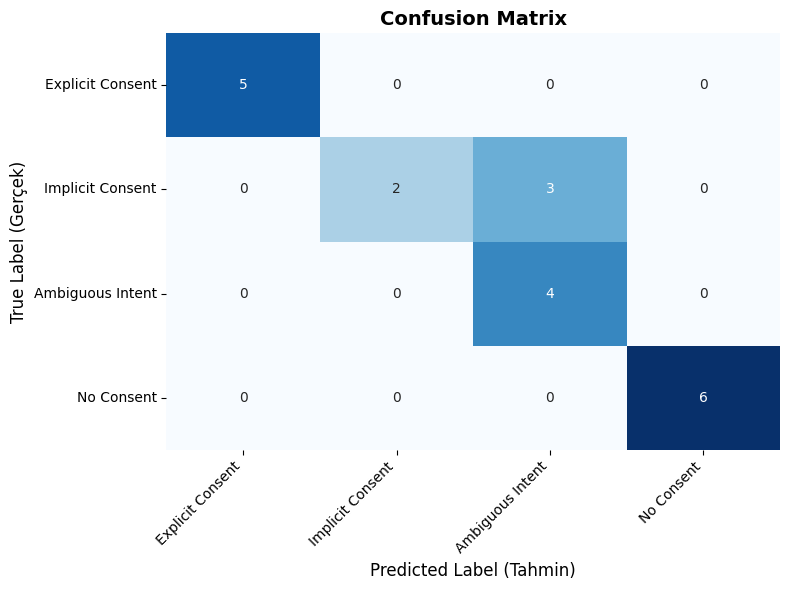

✅ 'confusion_matrix.png' oluşturuldu.


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label (Gerçek)', fontsize=12)
    plt.xlabel('Predicted Label (Tahmin)', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()
    print("✅ 'confusion_matrix.png' oluşturuldu.")


class_names = ["Explicit Consent", "Implicit Consent", "Ambiguous Intent", "No Consent"]


plot_confusion_matrix(y_true, y_pred, class_names)